In [3]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import json
import cv2
import tensorflow as tf
from tensorflow import keras
import os
import datetime
from mano import Mano
from glob import glob
import time
import scipy
import sys

In [4]:
# tf.debugging.experimental.enable_dump_debug_info("./logs/tfdbg2_logdir",
#     tensor_debug_mode="FULL_HEALTH",
#     circular_buffer_size=-1)

# Global Constants

In [5]:
EPSILON = 0.0001             ## 
AUGMENT = 1                  ## Add image augmentation (introduce random clipping, rotation and scaling)
PAD = 30                     ## 
SEQ_LENGTH = 8               ##Spiral convolulational neighbourhood length
OUT_IMAGE_SIZE = (224, 224)  ## Paper says 192x192 crops

CROP_OFFSET_RANGE = [-5, 5]  ## 
ROTATION_RANGE = [-180, 180] ## 

## Hyperparameters
lamb_edge = 0.01             ##
lamb_vert = 0.01             ##
learning_rate = 0.1e-4

imagenet_mean=np.array([0.485, 0.456, 0.406])
imagenet_std=np.array([0.229, 0.224, 0.225])

# Data reading 
In this case a single image and its corresponding annotation

In [6]:
with open('../storage/correct_sample.json') as f:
    train_data = json.load(f)

In [7]:
print("Data keys:", [k for k in train_data.keys()])
print("Image keys:", [k for k in train_data['images'][0].keys()])
print("Annotations keys:", [k for k in train_data['annotations'][0].keys()])

print("The number of images:", len(train_data['images']))
print("The number of annotations:", len(train_data['annotations']))

Data keys: ['images', 'annotations']
Image keys: ['id', 'name', 'height', 'width']
Annotations keys: ['vertices', 'is_left', 'image_id', 'id']
The number of images: 1
The number of annotations: 1


In [8]:
def retrieve_sample(data, image_name):
    """
    Retrieve annotations for a particular image
    """
    annotation_list = []
    image = None
    for im in data['images']:
        if im['name'] == image_name:
            image = im
    
    for ann in data['annotations']:
        if ann['image_id'] == image['id']:
            annotation_list.append(ann)

    return annotation_list, image

In [9]:
def visualize_in_orig_image(image_path, width, height, annotations):
    """
    Visualize hand annotations and image on uncropped original image
    """
    image = Image.open(image_path)
    image = image.resize((width, height), 2)
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    vertices = np.array(annotations['vertices'])
    plt.plot(vertices[:, 0], vertices[:, 1], 'o', color='green', markersize=1)
    plt.show()

In [10]:
# Get the cropped image at this stage
annotation_list, image  = retrieve_sample(train_data, train_data['images'][0]['name'])

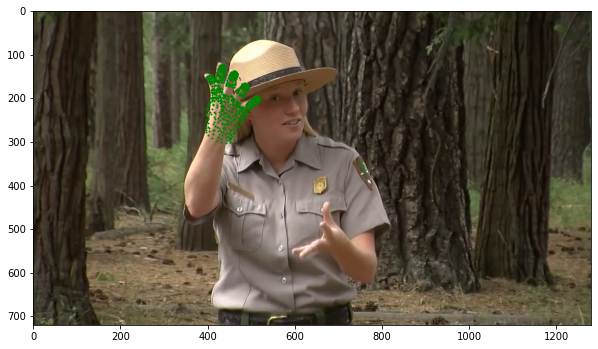

In [11]:
visualize_in_orig_image('../storage/data/'+image['name'], image['width'], image['height'], annotation_list[0])

# Image data and annotations processing

In [12]:
def translation_mat(tx=0, ty=0, tz=0):
    """
    4x4 translational matrix
    """
    mat = np.eye(4)
    mat[0:3, 3] = np.array([tx, ty, tz]).T
    return mat

def scaling_mat(sx=1, sy=1, sz=1):
    """
    4x4 scaling matrix
    """
    return np.diag([sx, sy, sz, 1])

In [13]:
def bounding_box(points, augment=1):
    """
    Get the hand's bounding box based on annotation coordinates
    """
    x_coordinates, y_coordinates, z_coordinates = zip(*points)
    random_offsets = np.random.randint(*CROP_OFFSET_RANGE, (2, 3))
    return np.array([[min(x_coordinates), min(y_coordinates), min(z_coordinates)], [max(x_coordinates), max(y_coordinates), max(z_coordinates)]])+random_offsets*augment

def shift_vertices(vertex_set, augment=1, pad=PAD):
    """
    Shift vertices based on the crop of hand from image
    """
    bbx = bounding_box(vertex_set).astype(int)
    mat = translation_mat(*(-1*(bbx[0,:]-pad)))
    adjusted_vertices = np.hstack([vertex_set.copy(), np.ones((len(vertex_set), 1))])
    adjusted_vertices = (adjusted_vertices @ mat.T)
    return adjusted_vertices, mat, bbx

def flip_hand(adjusted_vertices, mat, cropped_image, is_left):
    """
    Flip left hand vertex set to mirrored right hand coordinates
    """
    flip_mat = np.eye(4)
    if is_left:
        cropped_image = cropped_image[:, -1::-1, :]
        flip_mat = translation_mat(cropped_image.shape[1])
        flip_mat[0, 0] = -1
        adjusted_vertices = adjusted_vertices @ flip_mat.T
    return cropped_image, adjusted_vertices, flip_mat

def crop_image(image, width, height, bbx, pad=PAD):
    """
    Image cropping with pad dimensions to include local environment
    """
    image = np.asarray(image.resize((width, height), 2))
    cropped_image = image[bbx[0][1]-pad:bbx[1][1]+pad, bbx[0][0]-pad:bbx[1][0]+pad, :]
    return cropped_image

In [14]:
def visualize_in_processed_image(image_path, width, height, annotations):
    """
    Visualize hand annotations and image on original image after doing the cropping
    """
    image = Image.open(image_path)
    adjusted_vertices, mat, bbx = shift_vertices(annotations['vertices'])
    cropped_image = crop_image(image, width, height, bbx)
    plt.imshow(cropped_image)
    vertices = np.array(adjusted_vertices)
    plt.plot(adjusted_vertices[:, 0], adjusted_vertices[:, 1], 'o', color='green', markersize=1)
    plt.show()
    
def plot_and_show(image, vertex_set=None):
    """
    Visualize on already cropped input image and annotation set
    """
    plt.imshow(image)
    if vertex_set is not None:
        plt.plot(vertex_set[:, 0], vertex_set[:, 1], 'o', color='green', markersize=1)
    plt.show()    

def plot_vertices(vertex_set):
    """
    Plot vertices as a 2D image
    """
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(vertex_set[:, 0], vertex_set[:, 1], "go")
    ax.set_aspect("equal")
    ax.invert_yaxis()
    plt.show()
    
def viz_3d(vertices, faces):
    """
    Generate 3D visualisation of vertices
    """
    import open3d as o3d
    
    mesh = o3d.geometry.TriangleMesh(o3d.utility.Vector3dVector(vertices), o3d.utility.Vector3iVector(faces))
    o3d.visualization.draw_geometries([mesh])

In [15]:
def map_img_to_path(img_dct, images):
    """
    Preprocessing function to create a image id to details mapping
    """
    for i in images:
        if i['id'] not in img_dct:
            img_dct[i['id']] = {}
        img_dct[i['id']]['path'] = i['name']
        img_dct[i['id']]['width'] = i['width']
        img_dct[i['id']]['height'] = i['height']
        
def map_img_to_ann(img_dct, annotations):
    """
    Preprocessing function to create a image id to list of annotations
    """
    for idx, ann in enumerate(annotations):
        if ann['image_id'] not in img_dct:
            img_dct[ann['image_id']] = {}
        if 'ann' not in img_dct[ann['image_id']]:
            img_dct[ann['image_id']]['ann'] = []
        img_dct[ann['image_id']]['ann'].append(idx)

In [16]:
def get_edge_mat(face_data, num_vert):
    """
    Get edge matrix of dimension Num_edges x Num_vertices
    Example :- [[1, 0, 0, -1, 0...], .. .. ]
    """
    edge_list = []
    for f in face_data:
        edge_list.append((f[0], f[1]) if f[0]<f[1] else (f[1], f[0]))
        edge_list.append((f[1], f[2]) if f[1]<f[2] else (f[2], f[1]))
        edge_list.append((f[2], f[0]) if f[2]<f[0] else (f[0], f[2]))
    edge_list = list(set(edge_list))
    print(edge_list)
    edge_mat = np.zeros((len(edge_list), num_vert))
    for idx, e in enumerate(edge_list):
        edge_mat[idx, e[0]]=1
        edge_mat[idx, e[1]]=-1
    return edge_mat

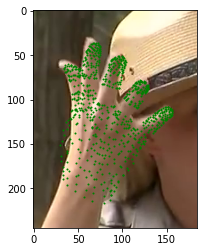

In [17]:
visualize_in_processed_image('../storage/data/'+image['name'], image['width'], image['height'], annotation_list[0])

In [18]:
# Process vertex set and image (Pipeline for a single image)
shifted_vertices, mat, bbx = shift_vertices(annotation_list[0]['vertices'])
orig_image = Image.open('../storage/data/'+image['name'])
cropped_image = crop_image(orig_image, image['width'], image['height'], bbx)

cropped_image, flipped_vertices, flip_mat = flip_hand(shifted_vertices, mat, cropped_image, 1)

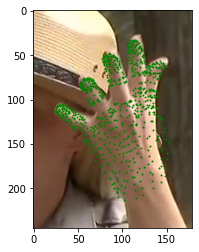

In [19]:
plot_and_show(cropped_image, flipped_vertices)

In [20]:
width = cropped_image.shape[1]
height = cropped_image.shape[0]
# print(width, height)

large_side = max(width, height)
scale = OUT_IMAGE_SIZE[0] / large_side

# image = image.thumbnail(OUT_IMAGE_SIZE, Image.ANTIALIAS)
scaled_image = Image.fromarray(cropped_image).resize((int(scale * width), int(scale * height)), 2)
# print(width*scale, height*scale)

scale_mat = scaling_mat(scale, scale)
width_padding = int(OUT_IMAGE_SIZE[0] - scale * width)
height_padding = int(OUT_IMAGE_SIZE[0] - scale * height)

pad_mat = translation_mat( width_padding/2, height_padding/2)
padded_image = Image.new("RGB", OUT_IMAGE_SIZE)
padded_image.paste(scaled_image, (width_padding//2, height_padding//2))

scaled_vertices = flipped_vertices @ scale_mat.T
padded_vertices = scaled_vertices @ pad_mat.T

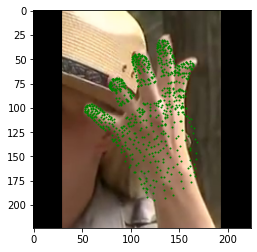

In [21]:
plot_and_show(padded_image, padded_vertices)

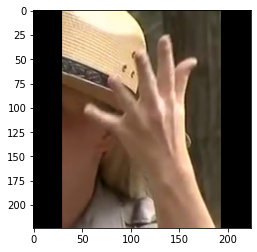

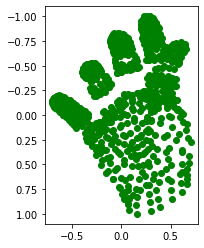

In [22]:
new_bbx = bounding_box(padded_vertices[:, 0:3], 0)
padded_image = np.array(padded_image)
normalized_image = padded_image / 255
# print(normalized_image.max())
plot_and_show(normalized_image)

vertex_scale = new_bbx[1, :] - new_bbx[0, :]
vertex_scale[:] = vertex_scale.max()/2
normalize_mat = (translation_mat(*((- new_bbx[0, :] - new_bbx[1, :])/2)).T @
                    scaling_mat(*(1/(vertex_scale+EPSILON))).T).T
normalized_vertices = padded_vertices @ normalize_mat.T

plot_vertices(normalized_vertices)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


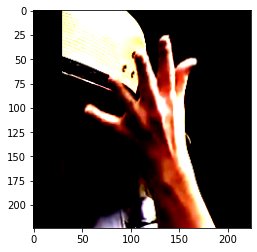

In [23]:
## Dataset Normalization (Images)
intensity_normalized_image = (normalized_image - imagenet_mean)/imagenet_std
plot_and_show(intensity_normalized_image)
## Normalize anns using dataset stats

In [24]:
def process_data(image, image_width, image_height, hand_is_left, annotation, augment):
    """
    Cumulative function for input data processing
    """
    shifted_vertices, mat, bbx = shift_vertices(annotation, augment)
    cropped_image = crop_image(image, image_width, image_height, bbx)

    cropped_image, flipped_vertices, flip_mat = flip_hand(shifted_vertices, mat, cropped_image, hand_is_left)
    
    width = cropped_image.shape[1]
    height = cropped_image.shape[0]

    large_side = max(width, height)
    scale = OUT_IMAGE_SIZE[0] / large_side

    scaled_image = Image.fromarray(cropped_image).resize((int(scale * width), int(scale * height)), 2)

    scale_mat = scaling_mat(scale, scale)
    width_padding = int(OUT_IMAGE_SIZE[0] - scale * width)
    height_padding = int(OUT_IMAGE_SIZE[0] - scale * height)

    pad_mat = translation_mat( width_padding/2, height_padding/2)
    padded_image = Image.new("RGB", OUT_IMAGE_SIZE)
    padded_image.paste(scaled_image, (width_padding//2, height_padding//2))

    scaled_vertices = flipped_vertices @ scale_mat.T
    padded_vertices = scaled_vertices @ pad_mat.T
    
    new_bbx = bounding_box(padded_vertices[:, 0:3], 0)
    padded_image = np.array(padded_image)
    normalized_image = padded_image / 255.0
    
    vertex_scale = new_bbx[1, :] - new_bbx[0, :]
    vertex_scale[:] = vertex_scale.max()/2
    normalize_mat = (translation_mat(*((- new_bbx[0, :] - new_bbx[1, :])/2)).T @
                        scaling_mat(*(1/(vertex_scale+EPSILON))).T).T

    #### IMP How to dataset normalize annotations ???
    normalized_vertices = padded_vertices @ normalize_mat.T
    
    intensity_normalized_image = (normalized_image - imagenet_mean) / imagenet_std
    
    
    affine_mat = pad_mat @ scale_mat @ flip_mat @ mat
    return annotation, normalized_image, normalized_vertices[:, :3], affine_mat[:3, :3]

In [25]:
def process_data_wrapper(image_path, image_width, image_height, hand_is_left, annotation_idx, augment):
    """
    Perform input data reading and calling cumulative processing function
    """
    annotations = train_data['annotations'][annotation_idx.numpy()]['vertices']
    image = Image.open(image_path.numpy())
    
    image_height = image_height.numpy()
    image_width = image_width.numpy()
    hand_is_left = hand_is_left.numpy()
    
    annotations_uvd, normalized_image, normalized_annotations, affine_mat = process_data(image, image_width, image_height, hand_is_left, annotations, augment)
    
    return annotations_uvd, normalized_image, normalized_annotations, affine_mat

In [26]:
def get_raw_data_as_tf_dataset(storage_dir, images, annotations):
    image_dct = {}
    image_path = []
    image_width = []
    image_height = []
    hand_is_left = []
    annotation_idx = []
    map_img_to_path(image_dct, images)
    map_img_to_ann(image_dct, annotations)
    for idx, img in enumerate(image_dct.keys()):
        image_dct[img]['path'] = os.path.join(storage_dir, image_dct[img]['path'])
        for ann in image_dct[img]['ann']:
            image_path.append(image_dct[img]['path'])
            image_width.append(image_dct[img]['width'])
            image_height.append(image_dct[img]['height'])
            hand_is_left.append(annotations[ann]['is_left'])
            annotation_idx.append(ann)

        if idx > 2000:
            break
        
    
    ds_raw = tf.data.Dataset.from_tensor_slices((image_path, image_width, image_height, hand_is_left, annotation_idx))

    return ds_raw

In [27]:
def process_ds(image_path, image_width, image_height, hand_is_left, annotation_idx, augment):
    #Load image and annotations from text file later
    
    annotations_uvd, normalized_image, normalized_annotations, affine_mat = tf.py_function(
        func = process_data_wrapper,
        inp = [image_path, image_width, image_height, hand_is_left, annotation_idx, augment],
        Tout = [tf.float32, tf.float32, tf.float32, tf.float32]
    )
    
    annotations_uvd.set_shape([778, 3])
    normalized_image.set_shape([OUT_IMAGE_SIZE[0], OUT_IMAGE_SIZE[1], 3])
    normalized_annotations.set_shape([778, 3])
    affine_mat.set_shape([3, 3])
    
#     return (
#         {"normalized_image" : normalized_image, "affine_mat" : affine_mat},
#         {"normalized_annotations" : normalized_annotations, "annotations_uvd" : annotations_uvd}
#     )
    return normalized_image, normalized_annotations

In [28]:
def process_tf_dataset(ds_raw, augment):
    ds_processed = ds_raw.map(
                        lambda image_path, image_width, image_height, hand_is_left, annotation_id : process_ds(
                                image_path, image_width, image_height, hand_is_left, annotation_id, augment))
    
    return ds_processed

In [29]:
def get_processed_dataset_as_tf_dataset(storage_dir, images, annotations):
    ds_raw = get_raw_data_as_tf_dataset(storage_dir, images, annotations)
    
    n_data = ds_raw.cardinality().numpy()
    train_frac = 1
    n_data_train = int(n_data * train_frac)
    ds_train = ds_raw.take(n_data_train)
    ds_val = ds_raw.skip(n_data_train)
    
    ds_train = process_tf_dataset(ds_train, True)
    ds_train = ds_train.apply(tf.data.experimental.ignore_errors())
    ds_val = process_tf_dataset(ds_val, False)

    return ds_train, ds_val
    

In [30]:
ds_train, ds_val = get_processed_dataset_as_tf_dataset('../storage/data', train_data['images'], train_data['annotations'])

In [31]:
ds_train = ds_train.shuffle(1000).batch(32)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)
ds_val = ds_val.batch(32)
ds_val = ds_val.prefetch(tf.data.experimental.AUTOTUNE)

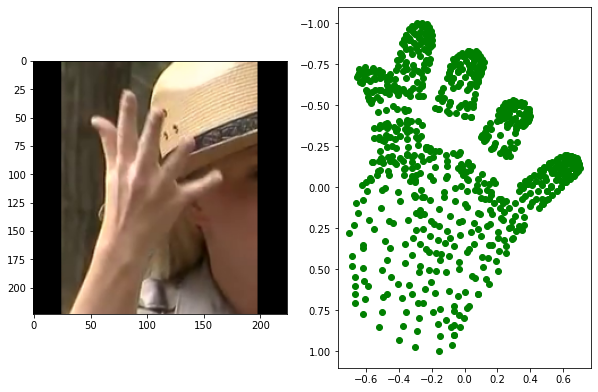

In [32]:
#Check output
fig = plt.figure(figsize=(10,10))
for ds in ds_train:
    plt.subplot(121)
    plt.imshow(ds[0][0].numpy())
    ax = fig.add_subplot(122)
    vertex_set = ds[1][0].numpy()
    ax.plot(vertex_set[:, 0], vertex_set[:, 1], "go")
    ax.set_aspect("equal")
    ax.invert_yaxis()
    break

In [33]:
mano = Mano('../storage/MANO_RIGHT.pkl')

In [34]:
sparse_edge_mat = tf.convert_to_tensor(get_edge_mat(mano.triangles, len(mano.V_temp)), dtype=tf.float32)

[(566, 567), (716, 731), (193, 229), (358, 375), (587, 590), (491, 504), (74, 288), (645, 648), (336, 337), (174, 176), (525, 557), (468, 469), (692, 693), (472, 475), (238, 280), (682, 684), (421, 430), (42, 88), (498, 509), (499, 505), (560, 571), (144, 274), (116, 118), (389, 395), (603, 620), (506, 508), (754, 755), (425, 447), (544, 547), (619, 620), (121, 214), (33, 34), (529, 530), (415, 422), (36, 41), (735, 745), (61, 63), (657, 661), (550, 566), (719, 720), (12, 129), (325, 326), (440, 453), (155, 273), (410, 452), (400, 408), (201, 627), (397, 453), (128, 172), (160, 162), (550, 553), (635, 658), (135, 173), (501, 503), (104, 287), (243, 257), (595, 596), (636, 658), (70, 72), (723, 731), (44, 120), (190, 235), (390, 404), (688, 694), (697, 712), (76, 246), (446, 448), (765, 766), (468, 482), (97, 773), (354, 355), (722, 723), (432, 435), (35, 110), (325, 328), (753, 754), (229, 231), (638, 669), (44, 119), (559, 560), (70, 777), (533, 538), (532, 534), (644, 645), (424, 427

In [35]:
sparse_edge_mat.shape

TensorShape([2315, 778])

In [36]:
def get_sparse_edge_mat(edge_mat):
    """
    edge_mat: Num_edges_in_face*778 
    """
    edge_mat = scipy.sparse.csr_matrix(edge_mat)
    edge_mat = edge_mat.tocoo()
    indices = np.column_stack((edge_mat.row, edge_mat.col))
    edge_mat = tf.SparseTensor(indices, edge_mat.data, edge_mat.shape)
    edge_mat = tf.sparse.reorder(edge_mat)
    return edge_mat

In [37]:
tensor_edge_mat = get_sparse_edge_mat(sparse_edge_mat)

In [38]:
faces = [[1, 2, 3], [3, 4, 1], [4, 3, 8], [8, 5, 4], [5, 8, 7], [7, 6, 5], [6, 7, 2], [2, 1, 6], [1, 4, 5], [5, 6, 1], [8, 3, 2], [2, 7, 8]]
faces = list(np.array(faces)-1)
edge_mat = get_edge_mat(faces, 8)
print(edge_mat, edge_mat.shape)

[(0, 1), (1, 2), (2, 7), (4, 7), (6, 7), (4, 6), (5, 6), (4, 5), (1, 5), (2, 3), (1, 6), (0, 5), (0, 4), (3, 7), (0, 3), (3, 4), (0, 2), (1, 7)]
[[ 1. -1.  0.  0.  0.  0.  0.  0.]
 [ 0.  1. -1.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0. -1.]
 [ 0.  0.  0.  0.  1.  0.  0. -1.]
 [ 0.  0.  0.  0.  0.  0.  1. -1.]
 [ 0.  0.  0.  0.  1.  0. -1.  0.]
 [ 0.  0.  0.  0.  0.  1. -1.  0.]
 [ 0.  0.  0.  0.  1. -1.  0.  0.]
 [ 0.  1.  0.  0.  0. -1.  0.  0.]
 [ 0.  0.  1. -1.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0. -1.  0.]
 [ 1.  0.  0.  0.  0. -1.  0.  0.]
 [ 1.  0.  0.  0. -1.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0. -1.]
 [ 1.  0.  0. -1.  0.  0.  0.  0.]
 [ 0.  0.  0.  1. -1.  0.  0.  0.]
 [ 1.  0. -1.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0. -1.]] (18, 8)


In [39]:
tfspm = tf.convert_to_tensor(edge_mat, dtype=tf.float64)
tfspm = get_sparse_edge_mat(edge_mat)
tf.print(tfspm)
tensor_edge_mat = tfspm

'SparseTensor(indices=[[0 0]
 [0 1]
 [1 1]
 ...
 [16 2]
 [17 1]
 [17 7]], values=[1 -1 1 ... -1 1 -1], shape=[18 8])'


In [40]:
vertices = [[0, 1, 0], [0, 0, 0], [1, 0, 0], [1, 1, 0], [1, 1, -1], [0, 1, -1], [0, 0, -1], [1, 0, -1]]
y_true = [vertices]
y_true = tf.convert_to_tensor(y_true, dtype=tf.float64)

y_pred = [np.array(vertices)-[0, 1, 0]]
y_pred = tf.convert_to_tensor(y_pred, dtype=tf.float64)

In [41]:
def loss_function1(y_true, y_pred):
    num_verts = tf.shape(y_true)[1]
    num_edges = tf.shape(tensor_edge_mat)[0]
    y_true = tf.transpose(y_true, perm=[1, 2, 0]) # 778 x 3 x N
    y_true = tf.reshape(y_true, [num_verts, -1])
    y_pred = tf.transpose(y_pred, perm=[1, 2, 0]) # 778 x 3 x N
    y_pred = tf.reshape(y_pred, [num_verts, -1])
    edge_true = tf.sparse.sparse_dense_matmul(tensor_edge_mat, y_true) # num_edges x 3N
    edge_pred = tf.sparse.sparse_dense_matmul(tensor_edge_mat, y_pred) # num_edges x 3N
    edge_pred = tf.reshape(edge_pred, [num_edges, 3, -1])
    edge_true = tf.reshape(edge_true, [num_edges, 3, -1])
    y_pred = tf.reshape(y_pred, [num_verts, 3, -1])
    y_true = tf.reshape(y_true, [num_verts, 3, -1])

#     tf.print(tf.shape(y_true), tf.shape(tf.reduce_sum(tf.norm(y_true - y_pred, ord=1, axis=1), axis=0)), tf.shape(tf.reduce_sum(tf.abs(tf.norm(edge_true, ord='euclidean', axis=1)**2 - tf.norm(edge_pred, ord='euclidean', axis=1)**2), axis=0)), output_stream=sys.stdout)
#     tf.print(tf.norm(edge_true, ord='euclidean', axis=1) - tf.norm(edge_pred, ord='euclidean', axis=1) , output_stream=sys.stdout)
#     tf.print(tf.reduce_mean(tf.norm(y_true - y_pred, ord=1, axis=1), axis=-1) , output_stream=sys.stdout)
#     tf.print(tf.reduce_mean(tf.reduce_mean(tf.abs(tf.norm(edge_true, ord=2, axis=1) - tf.norm(edge_pred, ord=2, axis=1)), axis=-1), axis=-1))
#     tf.print(tf.reduce_max(tf.abs(tf.norm(edge_true, ord=2, axis=1) - tf.norm(edge_pred, ord=2, axis=1))), output_stream=sys.stdout)
#     tf.autograph.trace()
#     tf.autograph.trace()

#     return lamb_vert * tf.reduce_mean(tf.reduce_sum(tf.norm(y_true - y_pred, ord=1, axis=1), axis=0)) + lamb_edge * tf.reduce_mean(tf.reduce_sum(tf.abs(tf.norm(edge_true, ord='euclidean', axis=1)**2 - tf.norm(edge_pred, ord='euclidean', axis=1)**2), axis=0))
    return lamb_vert * tf.reduce_mean(tf.reduce_sum(tf.norm(y_true - y_pred, ord=1, axis=1), axis=0))

In [42]:
# 8 vertices each shifted by magnitude of 1 so 0.01 * 8 = 0.08
tf.print(loss_function1(y_true, y_pred))

0.08


In [63]:
def loss_function2(y_true, y_pred):
    num_verts = tf.shape(y_true)[1]
    num_edges = tf.shape(tensor_edge_mat)[0]
    y_true = tf.transpose(y_true, perm=[1, 2, 0]) # 778 x 3 x N
    y_true = tf.reshape(y_true, [num_verts, -1])
    y_pred = tf.transpose(y_pred, perm=[1, 2, 0]) # 778 x 3 x N
    y_pred = tf.reshape(y_pred, [num_verts, -1])
    edge_true = tf.sparse.sparse_dense_matmul(tensor_edge_mat, y_true) # num_edges x 3N
    edge_pred = tf.sparse.sparse_dense_matmul(tensor_edge_mat, y_pred) # num_edges x 3N
    edge_pred = tf.reshape(edge_pred, [num_edges, 3, -1])
    edge_true = tf.reshape(edge_true, [num_edges, 3, -1])
    y_pred = tf.reshape(y_pred, [num_verts, 3, -1]) # 778 x 3 x N
    y_pred = tf.transpose(y_pred, perm=[2, 0, 1]) # N x 778 x 3
    y_true = tf.reshape(y_true, [num_verts, 3, -1])
    y_true = tf.transpose(y_true, perm=[2, 0, 1]) # N x 778 x 3

#     tf.print(tf.shape(y_true), tf.shape(tf.reduce_sum(tf.norm(y_true - y_pred, ord=1, axis=1), axis=0)), tf.shape(tf.reduce_sum(tf.abs(tf.norm(edge_true, ord='euclidean', axis=1)**2 - tf.norm(edge_pred, ord='euclidean', axis=1)**2), axis=0)), output_stream=sys.stdout)
#     tf.print(tf.norm(edge_true, ord='euclidean', axis=1) - tf.norm(edge_pred, ord='euclidean', axis=1) , output_stream=sys.stdout)
#     tf.print(tf.reduce_mean(tf.norm(y_true - y_pred, ord=1, axis=1), axis=-1) , output_stream=sys.stdout)
#     tf.print(tf.reduce_mean(tf.reduce_mean(tf.abs(tf.norm(edge_true, ord=2, axis=1) - tf.norm(edge_pred, ord=2, axis=1)), axis=-1), axis=-1))
#     tf.print(tf.reduce_max(tf.abs(tf.norm(edge_true, ord=2, axis=1) - tf.norm(edge_pred, ord=2, axis=1))), output_stream=sys.stdout)
#     tf.autograph.trace()
#     tf.autograph.trace()

    return lamb_vert * tf.reduce_mean(tf.reduce_sum(tf.norm(y_true - y_pred, ord=1, axis=2), axis=1)) + lamb_edge * tf.reduce_mean(tf.reduce_sum(tf.abs(tf.norm(edge_true, ord='euclidean', axis=1)**2 - tf.norm(edge_pred, ord='euclidean', axis=1)**2), axis=0))

In [59]:
class Error_Metric(tf.keras.metrics.Metric):
    def __init__(self, scale, **kwargs):
        super(Error_Metric, self).__init__(**kwargs)
        self.vertex_distance_error = self.add_weight(name="vertex_dist_error", initializer='zeros')
        self.mean_error = self.add_weight(name="mean_vertex_dist_error", initializer='zeros')
        self.steps = self.add_weight(name="steps", initializer='zeros')
        self.scale = scale

    def update_state(self, y_true, y_pred):
        self.vertex_distance_error = tf.reduce_mean(tf.reduce_sum(tf.norm(y_true - y_pred, ord=1, axis=2), axis=1)) * scale
        self.mean_error.assign_add(self.vertex_distance_error)
        self.steps.assign_add(1)

    def result(self):
        return (self.mean_error / self.steps, self.vertex_distance_error)

    def reset_states(self):
        self.mean_error.assign(0.0)
        self.steps.assign(0.0)

In [64]:
tf.print(loss_function2(y_true, y_pred))

0.08


In [46]:
inputs = tf.keras.Input(shape=(*OUT_IMAGE_SIZE, 3), name="normalized_image")

In [47]:
conv1 = tf.keras.layers.Conv2D(10, 3, 4, activation='relu', input_shape=(*OUT_IMAGE_SIZE, 3))

In [48]:
conv2 = tf.keras.layers.Conv2D(100, 5, 4, activation='relu', input_shape=(*OUT_IMAGE_SIZE, 3))

In [49]:
conv3 = tf.keras.layers.Conv2D(1000, 5, 4, activation='relu', input_shape=(*OUT_IMAGE_SIZE, 3))

In [50]:
avg_pool = tf.keras.layers.GlobalAveragePooling2D()

In [51]:
x = avg_pool(conv3(conv2(conv1(inputs))))

In [52]:
x = tf.keras.layers.Dense(778*3, activation=tf.keras.activations.relu, name="FC2")(x)

In [53]:
x = tf.keras.layers.Reshape((778, 3), name="reshape_to_mesh")(x)

In [54]:
outputs = x

In [55]:
model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [56]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalized_image (InputLayer [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 56, 56, 10)        280       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 100)       25100     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 1000)        2501000   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1000)              0         
_________________________________________________________________
FC2 (Dense)                  (None, 2334)              2336334   
_________________________________________________________________
reshape_to_mesh (Reshape)    (None, 778, 3)            0     

In [60]:
## Implement scheduler
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=loss_function2,
    metrics=[Error_Metric(1.0)]
)

In [61]:
model.fit(ds_train, batch_size=1, epochs=1000, validation_data=ds_val,steps_per_epoch=1)

Epoch 1/1000


TypeError: in user code:

    /Users/debabratamandal/sem8/RnD/code/RnD/virtual_env/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    <ipython-input-43-7a091d3c6ee9>:8 loss_function2  *
        edge_true = tf.sparse.sparse_dense_matmul(tensor_edge_mat, y_true) # num_edges x 3N
    /Users/debabratamandal/sem8/RnD/code/RnD/virtual_env/lib/python3.7/site-packages/tensorflow/python/ops/sparse_ops.py:2579 sparse_tensor_dense_matmul  **
        adjoint_b=adjoint_b)
    /Users/debabratamandal/sem8/RnD/code/RnD/virtual_env/lib/python3.7/site-packages/tensorflow/python/ops/gen_sparse_ops.py:3070 sparse_tensor_dense_mat_mul
        adjoint_b=adjoint_b, name=name)
    /Users/debabratamandal/sem8/RnD/code/RnD/virtual_env/lib/python3.7/site-packages/tensorflow/python/framework/op_def_library.py:558 _apply_op_helper
        inferred_from[input_arg.type_attr]))

    TypeError: Input 'b' of 'SparseTensorDenseMatMul' Op has type float32 that does not match type float64 of argument 'a_values'.


In [ ]:
pred = model.predict(np.array([rotated_and_scaled_image]), batch_size=1)

In [ ]:
viz_3d(pred[0], mano.triangles)

In [ ]:
plot_vertices(pred[0])

In [ ]:
model.save_weights('./my_checkpoint')